In [89]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps


from sklearn.metrics import accuracy_score, f1_score

import catboost
from catboost import CatBoostRanker, Pool, MetricVisualizer, CatBoostClassifier
from copy import deepcopy
from tqdm.notebook import tqdm

import seaborn as sns
sns.set(style='whitegrid', palette='Set2')
warnings.filterwarnings("ignore")

# Данные

Рассмотрим сами данные

In [4]:
df = pd.read_csv('intern_task.csv')
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


Описания у данных нет, поэтому сложно что-то сказать о самих признаках. Явно видны вещественные признаки. Есть признаки с ограниченным диапазоном, но для них сложно сказать задан на них порядок или нет или же это просто категория.

Посмотрим на уникальные ранги.

In [5]:
df['rank'].unique()

array([0, 1, 2, 4, 3])

Посчитаем количество уникальных query_id

In [6]:
len(df['query_id'].unique())

2000

Частоты признаков

In [7]:
df.groupby(['rank'])['rank'].count() / len(df)

rank
0    0.516544
1    0.322263
2    0.135638
3    0.017891
4    0.007664
Name: rank, dtype: float64

Здесь опять-таки нет описания таргета, поэтому сложно сделать вывод о том, какой ранк соответствует более релевантным документам

Посмотрим также на то, сколько объектов в каждом query_id, а точнее на распределение

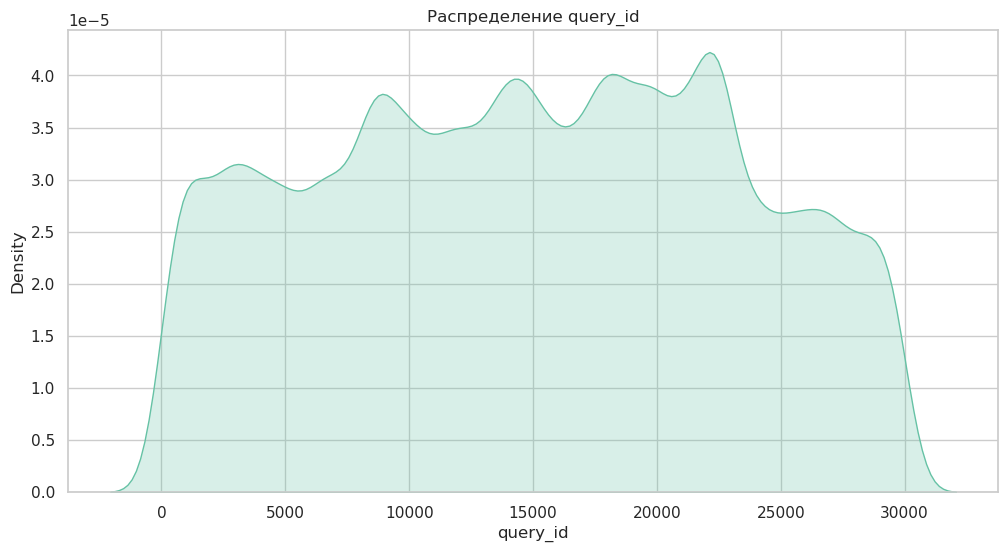

In [8]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df['query_id'], fill=True)
plt.title('Распределение query_id')
plt.show()

Видно, что распределение неравномерное. В каких-то query_id объектов больше, а в каких-то меньше

Разделим данные на train и test

In [9]:
features = [f'feature_{i}' for i in range(144)]

In [10]:
qid = np.array(df['query_id'].unique())
qid_train = np.random.choice(qid, replace=False, size=1600)
qid_train.sort()
mask = np.isin(qid, qid_train)
qid_test = qid[~mask]

In [11]:
df_train = df.loc[df['query_id'].isin(qid_train)]
df_test = df.loc[df['query_id'].isin(qid_test)]

In [12]:
X_train = df_train[[f'feature_{i}' for i in range(144)]]
X_test = df_test[[f'feature_{i}' for i in range(144)]]

y_train = df_train['rank']
y_test = df_test['rank']

qid_train = df_train['query_id']
qid_test = df_test['query_id']

Зададим пулы для работы CatBoostRanker

In [13]:
train = Pool(
    data=X_train,
    label=y_train,
    group_id=qid_train
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=qid_test
)

# Первый подход

Попробуем сначала просто обучить CatBoostRanker на всех фичах и посчитать метрики Precision@5, Recall@5, MAP@5, NDCG@5

In [14]:
default_parameters = {
    'iterations': 1000,
    'verbose': False,
}

parameters = {}

In [15]:
def fit_model(loss_function, plot_file, additional_params=None, train_pool=train, test_pool=test):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=True, plot_file=plot_file)

    return model

In [16]:
model = fit_model('YetiRank', 'model_1.html', {'custom_metric': ['PrecisionAt:top=5', 'RecallAt:top=5', 'MAP:top=5', 'NDCG:top=5']})

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
scores_rank_1 = model.best_score_
scores_rank_1

{'learn': {'RecallAt:top=5': 0.15715448275201338,
  'MAP:top=5': 0.7570154513888877,
  'PrecisionAt:top=5': 0.7827499999999961},
 'validation': {'NDCG:type=Base': 0.8033804785859986,
  'RecallAt:top=5': 0.15980252338217682,
  'NDCG:top=5;type=Base': 0.5967566925478716,
  'MAP:top=5': 0.6811583333333334,
  'PrecisionAt:top=5': 0.7289166666666675}}

Т.к. по итогу нужно предсказать ранк документа, то попробуем обучить CatBoostClassifier на выходе CatBoostRanker (т.е. на скорах).

In [21]:
preds_train = model.predict(train)
preds_test = model.predict(test)

df_test.loc[:, 'preds'] = preds_test
df_train.loc[:, 'preds'] = preds_train

In [29]:
classifier = CatBoostClassifier(verbose=100)
classifier.fit(df_train['preds'].values, y_train)

Learning rate set to 0.103402
0:	learn: 1.4870936	total: 30.9ms	remaining: 30.8s
100:	learn: 0.9673625	total: 2.74s	remaining: 24.4s
200:	learn: 0.9668545	total: 5.42s	remaining: 21.5s
300:	learn: 0.9665239	total: 8.06s	remaining: 18.7s
400:	learn: 0.9663154	total: 10.8s	remaining: 16.1s
500:	learn: 0.9661665	total: 13.5s	remaining: 13.4s
600:	learn: 0.9660484	total: 16.1s	remaining: 10.7s
700:	learn: 0.9659607	total: 18.7s	remaining: 7.98s
800:	learn: 0.9658806	total: 21.3s	remaining: 5.29s
900:	learn: 0.9658144	total: 23.8s	remaining: 2.62s
999:	learn: 0.9657642	total: 26.3s	remaining: 0us


In [30]:
preds = classifier.predict(df_test[features+['preds']])
df_test['preds_tree'] = preds

In [31]:
scores_classifier_1 = {'acc': accuracy_score(df_test['rank'], df_test['preds_tree']),
                      'f1': f1_score(df_test['rank'], df_test['preds_tree'], average='weighted')}

In [32]:
scores_classifier_1

{'acc': 0.24242691476696504, 'f1': 0.23799647534227544}

На самих скорах метрики Accuracy и F1 для классификации получились низкими, поэтому добавим к скорам все фичи и посмотрим, как изменятся метрики

In [33]:
classifier = CatBoostClassifier(verbose=100)
classifier.fit(df_train[features+['preds']], y_train)

Learning rate set to 0.103402
0:	learn: 1.4882995	total: 123ms	remaining: 2m 3s
100:	learn: 0.9336244	total: 10.1s	remaining: 1m 30s
200:	learn: 0.9119986	total: 20.5s	remaining: 1m 21s
300:	learn: 0.8966949	total: 31.2s	remaining: 1m 12s
400:	learn: 0.8844098	total: 41.6s	remaining: 1m 2s
500:	learn: 0.8736376	total: 52s	remaining: 51.8s
600:	learn: 0.8642073	total: 1m 2s	remaining: 41.2s
700:	learn: 0.8548169	total: 1m 12s	remaining: 30.9s
800:	learn: 0.8468412	total: 1m 22s	remaining: 20.6s
900:	learn: 0.8387778	total: 1m 33s	remaining: 10.2s
999:	learn: 0.8315976	total: 1m 43s	remaining: 0us


In [34]:
preds = classifier.predict(df_test[features+['preds']])
df_test['preds_tree'] = preds

In [35]:
scores_classifier_2 = {'acc': accuracy_score(df_test['rank'], df_test['preds_tree']),
                      'f1': f1_score(df_test['rank'], df_test['preds_tree'], average='weighted')}

In [36]:
scores_classifier_2

{'acc': 0.5559107544424358, 'f1': 0.5176744636235621}

Как видим, метрики сильно возросли

# Второй подход

Попробуем убрать сильно скоррелированные признаки и снова обучить CatBoostRanker и CatBoostClassifier, аналогично первому подходу

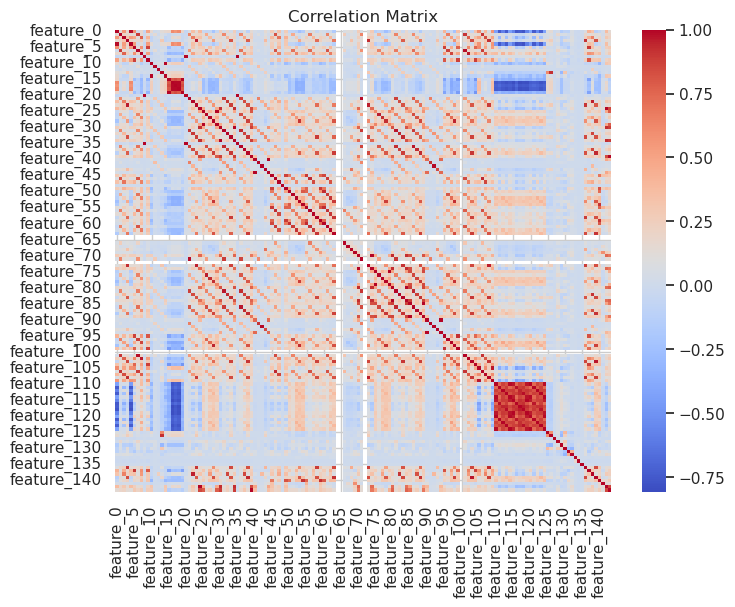

In [37]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.grid()
plt.title('Correlation Matrix')
plt.show()

Видно два красных кластера и два синих. Уберем именно их

In [38]:
feature_corr = [f'feature_{i}' for i in range(16, 20)] + [f'feature_{i}' for i in range(110, 124)]

In [39]:
filtered_X_train = X_train.drop(feature_corr, axis=1)
filtered_X_test = X_test.drop(feature_corr, axis=1)

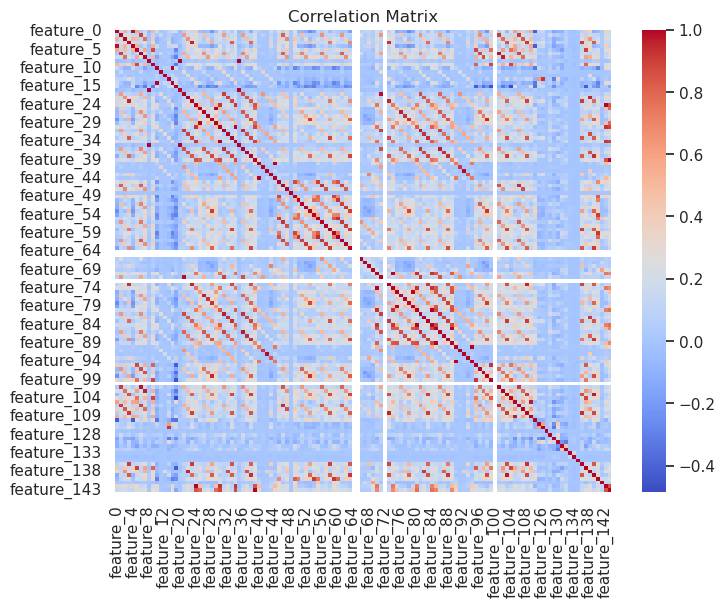

In [40]:
correlation_matrix = filtered_X_train.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Теперь скоррелированных признаков меньше. Повторим процедуру аналогично первому подходу

In [41]:
train = Pool(
    data=filtered_X_train,
    label=y_train,
    group_id=qid_train
)

test = Pool(
    data=filtered_X_test,
    label=y_test,
    group_id=qid_test
)

In [42]:
model = fit_model('YetiRank', 'model_2.html', 
                  {'custom_metric': ['PrecisionAt:top=5', 'RecallAt:top=5', 
                                                     'MAP:top=5', 'NDCG:top=5']}, 
                  train_pool=train, 
                  test_pool=test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [43]:
scores_rank_2 = model.best_score_

Обучаем классификатор

In [44]:
preds_train = model.predict(train)
preds_test = model.predict(test)

filtered_X_test['preds'] = preds_test
filtered_X_train['preds'] = preds_train

In [45]:
classifier = CatBoostClassifier(verbose=100)
classifier.fit(filtered_X_train, y_train)

Learning rate set to 0.103402
0:	learn: 1.4893276	total: 92.7ms	remaining: 1m 32s
100:	learn: 0.9373955	total: 10.7s	remaining: 1m 35s
200:	learn: 0.9176049	total: 20.8s	remaining: 1m 22s
300:	learn: 0.9040230	total: 30.4s	remaining: 1m 10s
400:	learn: 0.8926990	total: 39.9s	remaining: 59.6s
500:	learn: 0.8831225	total: 49.3s	remaining: 49.1s
600:	learn: 0.8740119	total: 58.7s	remaining: 39s
700:	learn: 0.8652406	total: 1m 8s	remaining: 29.1s
800:	learn: 0.8575821	total: 1m 17s	remaining: 19.2s
900:	learn: 0.8496777	total: 1m 26s	remaining: 9.52s
999:	learn: 0.8427263	total: 1m 35s	remaining: 0us


In [46]:
preds = classifier.predict(filtered_X_test)
df_test['preds_tree'] = preds

In [47]:
scores_classifier_3 = {'acc': accuracy_score(df_test['rank'], df_test['preds_tree']),
                      'f1': f1_score(df_test['rank'], df_test['preds_tree'], average='weighted')}

In [48]:
scores_classifier_3

{'acc': 0.5554918647206667, 'f1': 0.5178486583615257}

Метрики практически не изменились

# Третий подход

Посмотрим на feature importances CatBoostRanker, чтобы оценить важность признаков

In [49]:
imp = model.get_feature_importance(data=train)

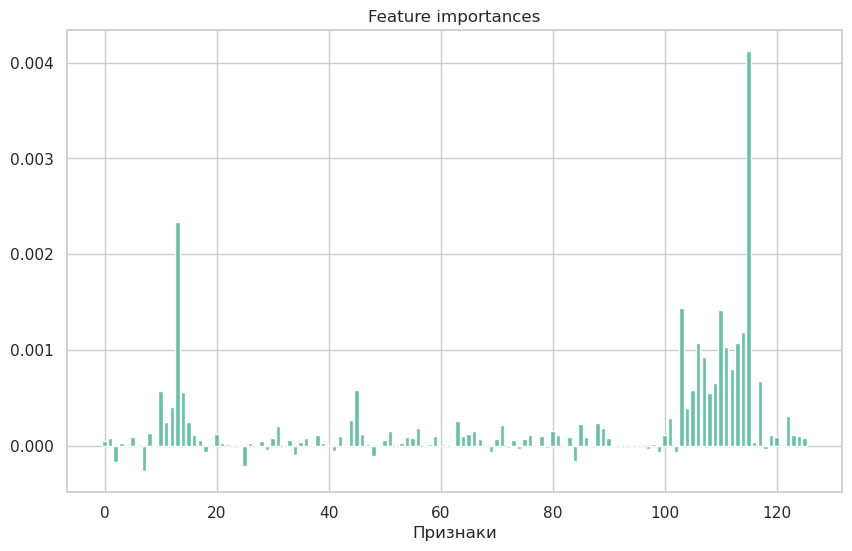

In [50]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(imp)), imp)
plt.title('Feature importances')
plt.xlabel('Признаки')
plt.show()

Видим, что достаточно много признаков CatBoostRanker оценивает как мало значимые, поэтому уберем половину признаков

In [51]:
filtered_X_train = filtered_X_train.drop('preds', axis=1)
filtered_X_test = filtered_X_test.drop('preds', axis=1)

Используем 0.5 квантиль в качестве threshold

In [52]:
X_train_final = filtered_X_train.loc[:, imp >= np.quantile(imp, q=0.5)]
X_test_final = filtered_X_test.loc[:, imp >= np.quantile(imp, q=0.5)]

Повторяем пайплайн обучения

In [53]:
train = Pool(
    data=X_train_final,
    label=y_train,
    group_id=qid_train
)

test = Pool(
    data=X_test_final,
    label=y_test,
    group_id=qid_test
)

In [54]:
model = fit_model('YetiRank', 'model_3.html', {'custom_metric': ['PrecisionAt:top=5', 'RecallAt:top=5', 
                                                     'MAP:top=5', 'NDCG:top=5']}, train_pool=train, test_pool=test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [55]:
scores_rank_3 = model.best_score_

In [56]:
preds_train = model.predict(train)
preds_test = model.predict(test)

X_test_final['preds'] = preds_test
X_train_final['preds'] = preds_train

In [57]:
classifier = CatBoostClassifier(verbose=100)
classifier.fit(X_train_final, y_train)

Learning rate set to 0.103402
0:	learn: 1.4922531	total: 78.3ms	remaining: 1m 18s
100:	learn: 0.9483780	total: 6.37s	remaining: 56.7s
200:	learn: 0.9287963	total: 12.8s	remaining: 51.1s
300:	learn: 0.9142619	total: 19.1s	remaining: 44.3s
400:	learn: 0.9027640	total: 25.4s	remaining: 38s
500:	learn: 0.8917767	total: 31.9s	remaining: 31.8s
600:	learn: 0.8826980	total: 38.4s	remaining: 25.5s
700:	learn: 0.8739874	total: 44.8s	remaining: 19.1s
800:	learn: 0.8659854	total: 51.3s	remaining: 12.7s
900:	learn: 0.8581442	total: 57.9s	remaining: 6.36s
999:	learn: 0.8508387	total: 1m 4s	remaining: 0us


In [58]:
preds = classifier.predict(X_test_final)
df_test['preds_tree'] = preds

In [59]:
scores_classifier_4 = {'acc': accuracy_score(df_test['rank'], df_test['preds_tree']),
                      'f1': f1_score(df_test['rank'], df_test['preds_tree'], average='weighted')}

In [60]:
scores_classifier_4

{'acc': 0.553419462939283, 'f1': 0.5135076029641874}

Метрики получились чуть ниже

# Итоги

Соберем полученные результаты в таблицы для сравнения

In [78]:
final_table_ranker = {
    'NDCG:type=Base': [],
 'RecallAt:top=5': [],
 'NDCG:top=5;type=Base': [],
 'MAP:top=5': [],
 'PrecisionAt:top=5': []
}

for i in [scores_rank_1['validation'], scores_rank_2['validation'], scores_rank_3['validation']]:
    for key, value in i.items():
        final_table_ranker[key].append(value)
        
final_table_classifier = {
    'acc': [], 
    'f1': []
}

for i in [scores_classifier_1, scores_classifier_2, scores_classifier_3, scores_classifier_4]:
    for key, value in i.items():
        final_table_classifier[key].append(value)

In [85]:
final_ranker = pd.DataFrame.from_dict(final_table_ranker)
final_ranker.index = ['Все фичи', 'Без скоррелированных фичей', 'Половина от feature importances']

In [86]:
final_ranker

,NDCG:type=Base,RecallAt:top=5,NDCG:top=5;type=Base,MAP:top=5,PrecisionAt:top=5
Все фичи,0.803380,0.159803,0.596757,0.681158,0.728917
Без скоррелированных фичей,0.804374,0.161810,0.597958,0.678892,0.724917
Половина от feature importances,0.799588,0.159324,0.584016,0.673008,0.721917


Как видим, если убирать скоррелированные фичи, то метрика NDCG немного возрастает, но остальные метрики падают в результате уменьшения числа фичей

In [87]:
final_classifier = pd.DataFrame.from_dict(final_table_classifier)
final_classifier.index = ['Только предсказания', 
                          'Предсказания + все фичи', 
                          'Предсказания + без скоррелированных фичей', 
                          'Предсказания + половина от feature importances']

In [88]:
final_classifier

,acc,f1
Только предсказания,0.242427,0.237996
Предсказания + все фичи,0.555911,0.517674
Предсказания + без скоррелированных фичей,0.555492,0.517849
Предсказания + половина от feature importances,0.553419,0.513508


Здесь ситуация практически аналогичная, подросла f1 метрика, если убрать скоррелированные фичи, но в общем они падают при  уменьшении числа фичей

**Вывод:** Лучше всего себя показала модель, обучающаяся на всех фичах